# Phase 4 Project - Sentiment Analysis of Depression in Tweets

![depression_tweeting](images/depression_tweeting.png)

**Name**:  Jordana Tepper  
**Pace**:  Full Time  
**Instructor**: Joseph Mata  

## Overview

## Business Understanding

## Data Understanding

In [1]:
import pandas as pd
import numpy as np
import string
import re
import matplotlib.pyplot as plt

# NLTK Imports
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, recall_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
# from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# from sklearn.base import BaseEstimator, TransformerMixin 

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline

In [2]:
# Loading in dataset
df = pd.read_csv('data/sentiment_tweets3.csv')

In [3]:
# Previewing dataset
df

,Index,message to examine,label (depression result)
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
...,...,...,...
10309,802309,No Depression by G Herbo is my mood from now o...,1
10310,802310,What do you do when depression succumbs the br...,1
10311,802311,Ketamine Nasal Spray Shows Promise Against Dep...,1
10312,802312,dont mistake a bad day with depression! everyo...,1


In [4]:
# Looking at missing values
df.isna().sum()

Index                        0
message to examine           0
label (depression result)    0
dtype: int64

There are no missing values.

In [5]:
# Looking at distribution of target
df['label (depression result)'].value_counts(normalize = True)

0    0.775645
1    0.224355
Name: label (depression result), dtype: float64

The dataset is imbalanced, so I will use SMOTE to fix this.

## Data Preparation

In [6]:
# Dropping last row because the entry is empty
df = df.drop(10313)

In [7]:
# Dropping index column
df = df.drop(columns = ['Index'], axis = 1)

In [8]:
# Renaming columns
df = df.rename(columns = {'message to examine':'tweet', 'label (depression result)': 'depression'})

## Modeling

**Due to the fact that the goal of my model is to aid Twitter in targeting those who appear depressed based on their tweets with advertisements about therapy and support, a false negative is more costly than a false positive.**

**Therefore, the metric that matters most in our project is recall.**

In [9]:
# Train test split
X = df['tweet']
y = df['depression']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

### Creating a Stemming and Tokenizing Function

In [10]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(language="english")
stopwords_list = stopwords.words('english')


from nltk.tokenize import RegexpTokenizer
basic_token_pattern = r"(?u)\b\w\w+\b"
tokenizer = RegexpTokenizer(basic_token_pattern)

In [11]:
def stem_and_tokenize(document):
    tokens = tokenizer.tokenize(document)
    return [stemmer.stem(token) for token in tokens]

In [12]:
stemmed_stopwords = [stemmer.stem(word) for word in stopwords_list]

### Visualizing Word Frequency

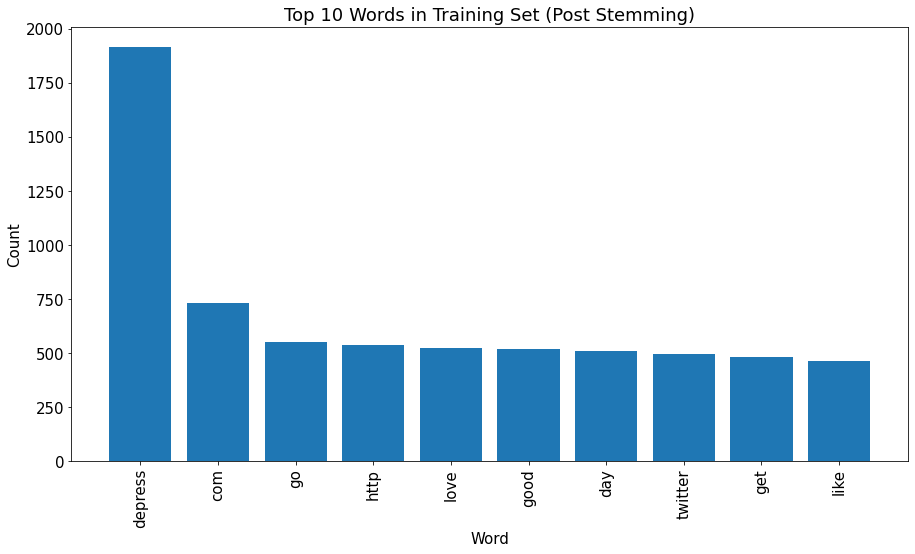

In [13]:
X_train_viz = X_train.apply(stem_and_tokenize)

def remove_stopwords(token_list):
    stopwords_removed = [token for token in token_list if token not in stemmed_stopwords]
    return stopwords_removed

X_train_viz = X_train_viz.apply(remove_stopwords)
freq_dist = FreqDist(X_train_viz.explode())


top_10 = list(zip(*freq_dist.most_common(10)))
tokens = top_10[0]
counts = top_10[1]

fig, ax = plt.subplots(figsize = (15,8))
ax.bar(tokens, counts)

plt.title("Top 10 Words in Training Set (Post Stemming)", fontdict = {'fontsize': 18})
plt.ylabel("Count", fontsize = 15)
plt.xlabel("Word", fontsize = 15)
ax.tick_params(axis="x", rotation=90, labelsize = 15)
ax.tick_params(axis="y", rotation=0, labelsize = 15)
plt.show()

### Model 1: Count Vectorizer and Random Forest

In [14]:
pipe_rfc_vec = Pipeline([
  ('vect', CountVectorizer(stop_words=stemmed_stopwords, tokenizer=stem_and_tokenize)),
   ('smote', SMOTE(random_state=42)),
   ('rfc', RandomForestClassifier(random_state = 42))
])

In [15]:
pipe_rfc_vec.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             "you'r", "you'v", "you'll",
                                             "you'd", 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'his', 'himself', 'she',
                                             'she', 'her', 'her', 'herself',
                                             'it', 'it', 'it', 'itself', ...],
                                 tokenizer=<function stem_and_tokenize at 0x7fafb08c21f0>)),
                ('smote', SMOTE(random_state=42)),
                ('rfc', RandomForestClassifier(random_state=42))])

In [16]:
y_preds_rfc_vec = pipe_rfc_vec.predict(X_test)

In [17]:
recall_score(y_test, y_preds_rfc_vec)

0.9730639730639731

In [18]:
# pipe_rfc_vec.score(X_test, y_test)

In [19]:
# Instantiate the vectorizer
# countvectorizer = CountVectorizer(
#                                   stop_words=stemmed_stopwords, 
#                                   tokenizer=stem_and_tokenize)

In [20]:
# Fit the vectorizer on X_train and transform it
# X_train_count_vec = countvectorizer.fit_transform(X_train)

In [21]:
# Visually inspect the vectorized train data
# pd.DataFrame.sparse.from_spmatrix(X_train_count_vec, columns=countvectorizer.get_feature_names())

In [22]:
# X_test_count_vec = countvectorizer.transform(X_test)

In [23]:
# # Visually inspect the vectorized test data
# pd.DataFrame.sparse.from_spmatrix(X_test_count_vec, columns=countvectorizer.get_feature_names())

In [24]:
# # Instantiate and fit a Random Forest model
# rfc = RandomForestClassifier(random_state = 42)
# rfc.fit(X_train_count_vec, y_train)

In [25]:
# y_preds_rfc = rfc.predict(X_test_count_vec)

In [26]:
# recall_score(y_test, y_preds_rfc)

In [27]:
# rfc.score(X_test_count_vec, y_test)

### Model 2: TF-IDF Vectorizer and Random Forest

In [28]:
pipe_rfc_tfidf = Pipeline([
  ('tfidf', TfidfVectorizer(stop_words=stemmed_stopwords, tokenizer=stem_and_tokenize)),
   ('smote', SMOTE(random_state=42)),
   ('rfc', RandomForestClassifier(random_state = 42))
])

In [29]:
pipe_rfc_tfidf.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             "you'r", "you'v", "you'll",
                                             "you'd", 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'his', 'himself', 'she',
                                             'she', 'her', 'her', 'herself',
                                             'it', 'it', 'it', 'itself', ...],
                                 tokenizer=<function stem_and_tokenize at 0x7fafb08c21f0>)),
                ('smote', SMOTE(random_state=42)),
                ('rfc', RandomForestClassifier(random_state=42))])

In [30]:
y_preds_rfc_tfidf = pipe_rfc_tfidf.predict(X_test)

In [31]:
recall_score(y_test, y_preds_rfc_tfidf)

0.9865319865319865

In [32]:
# pipe_rfc_tfidf.score(X_test, y_test)

In [33]:
# # Instantiate the vectorizer
# tfidf = TfidfVectorizer(
#     stop_words=stemmed_stopwords,
#     tokenizer=stem_and_tokenize
# )

In [34]:
# # Fit the vectorizer on X_train and transform it
# X_train_tfidf_vec = tfidf.fit_transform(X_train)

In [35]:
# # Visually inspect the vectorized train data
# pd.DataFrame.sparse.from_spmatrix(X_train_tfidf_vec, columns=tfidf.get_feature_names())

In [36]:
# # Transform the test data
# X_test_tfidf_vec = tfidf.transform(X_test)

In [37]:
# # Visually inspect the vectorized test data
# pd.DataFrame.sparse.from_spmatrix(X_test_tfidf_vec, columns=tfidf.get_feature_names())

In [38]:
# # NOT NEEDED
# from sklearn.model_selection import cross_val_score
# from sklearn.naive_bayes import MultinomialNB


# # Instantiate a MultinomialNB classifier
# baseline_model = MultinomialNB()
# stemmed_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
# stemmed_cv

In [39]:
# # Instantiate and fit a Random Forest model
# rfc_2 = RandomForestClassifier(random_state = 42)
# rfc_2.fit(X_train_tfidf_vec, y_train)

In [40]:
# y_preds_rfc2 = rfc_2.predict(X_test_tfidf_vec)

In [41]:
# recall_score(y_test, y_preds_rfc2)

In [42]:
# rfc_2.score(X_test_tfidf_vec, y_test)

### Model 3: Count Vectorizer and Multinomial Naive Bayes

In [43]:
pipe_mnb_vec = Pipeline([
  ('vect', CountVectorizer(stop_words=stemmed_stopwords, tokenizer=stem_and_tokenize)),
   ('smote', SMOTE(random_state=42)),
   ('mnb', MultinomialNB())
])

In [44]:
pipe_mnb_vec.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             "you'r", "you'v", "you'll",
                                             "you'd", 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'his', 'himself', 'she',
                                             'she', 'her', 'her', 'herself',
                                             'it', 'it', 'it', 'itself', ...],
                                 tokenizer=<function stem_and_tokenize at 0x7fafb08c21f0>)),
                ('smote', SMOTE(random_state=42)), ('mnb', MultinomialNB())])

In [45]:
y_preds_mnb_vec = pipe_mnb_vec.predict(X_test)

In [46]:
recall_score(y_test, y_preds_mnb_vec)

0.98989898989899

In [47]:
# pipe_mnb_vec.score(X_test, y_test)

### Model 4: TF-IDF and Multinomial Naive Bayes

In [48]:
pipe_mnb_tfidc = Pipeline([
  ('tfidf', TfidfVectorizer(stop_words=stemmed_stopwords, tokenizer=stem_and_tokenize)),
   ('smote', SMOTE(random_state=42)),
   ('mnb', MultinomialNB())
])

In [49]:
pipe_mnb_tfidc.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             "you'r", "you'v", "you'll",
                                             "you'd", 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'his', 'himself', 'she',
                                             'she', 'her', 'her', 'herself',
                                             'it', 'it', 'it', 'itself', ...],
                                 tokenizer=<function stem_and_tokenize at 0x7fafb08c21f0>)),
                ('smote', SMOTE(random_state=42)), ('mnb', MultinomialNB())])

In [50]:
y_preds_mnb_tfidf = pipe_mnb_tfidc.predict(X_test)

In [51]:
recall_score(y_test, y_preds_mnb_tfidf)

0.9848484848484849

In [52]:
# pipe_mnb_tfidc.score(X_test, y_test)

### Sample Data for Model 3

In [53]:
sample_1 = ['I am depressed']

In [54]:
pipe_mnb_vec.predict(sample_1)

array([1])

In [55]:
sample_2 = ['I want to die']

In [56]:
pipe_mnb_vec.predict(sample_2)

array([1])

In [57]:
sample_3 = ['Kill me']

In [58]:
pipe_mnb_vec.predict(sample_3)

array([1])

In [59]:
sample_4 = ['I want to kill myself']

In [60]:
pipe_mnb_vec.predict(sample_4) # Flawed

array([0])

In [61]:
sample_5 = ['i am depressed']

In [62]:
pipe_mnb_vec.predict(sample_5)

array([1])

In [63]:
sample_6 = ['I am not depressed']

In [64]:
pipe_mnb_vec.predict(sample_6) # Flawed

array([1])

In [65]:
sample_7 = ['I need help']

In [66]:
pipe_mnb_vec.predict(sample_7)

array([1])

In [67]:
sample_8 = ['My dog is so cute']

In [68]:
pipe_mnb_vec.predict(sample_8)

array([0])

In [69]:
sample_9 = ['I need a good new show to watch']

In [70]:
pipe_mnb_vec.predict(sample_9)

array([0])

In [71]:
sample_10 = ['School is so stressful']

In [72]:
pipe_mnb_vec.predict(sample_10)

array([1])

In [73]:
sample_11 = ["I'm so hungry, what should I eat?"]

In [74]:
pipe_mnb_vec.predict(sample_11)

array([0])

In [75]:
sample_12 = ['Procrasinating doing my homework']

In [76]:
pipe_mnb_vec.predict(sample_12)

array([0])

In [77]:
sample_13 = ['I am depro']

In [78]:
pipe_mnb_vec.predict(sample_13) # Flawed

array([0])

In [79]:
sample_14 = ['I am emo']

In [80]:
pipe_mnb_vec.predict(sample_14) # Flawed

array([0])

## Conclusions

### Limitations

- The model fails to understand slang words such as 'emo' and 'depro'
- The model also fails to properly interpret negation in statements such as, "I am NOT depressed" or "I am NOT okay"
- These two limitations likely root from the fact that this dataset contains only 10,313 tweets meaning that the model cannot capture every pattern of text that exists online.

### Next Steps

If I had access to more data, I would do the following:

- Acquire a larger dataset
- Acquire more data that accounts for slang words
- Develop models that incorporates other languages